<a href="https://colab.research.google.com/github/Eminent01/AMMI_Research/blob/main/AMMI_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!git clone https://github.com/Eminent01/DDPG_TD3_PortfolioOptimization_tensorflow-1.15.4.git

Cloning into 'DDPG_TD3_PortfolioOptimization_tensorflow-1.15.4'...
remote: Enumerating objects: 922, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 922 (delta 13), reused 10 (delta 8), pack-reused 893
Receiving objects: 100% (922/922), 244.82 MiB | 26.52 MiB/s, done.
Resolving deltas: 100% (257/257), done.
Updating files: 100% (262/262), done.


In [5]:
%cd "/content/DDPG_TD3_PortfolioOptimization_tensorflow-1.15.4/"
!ls
!mv * ../

/content/DDPG_TD3_PortfolioOptimization_tensorflow-1.15.4
 config
 dictionaries
 ensemble_strategy.py
 environment
'Finding Threshold Value for Training TD3 models.ipynb'
 model
'On-line Portfolio Selection.ipynb'
 README.md
 requirements.txt
 results
 stock_trading.py
'TD3 vs TD3-rmr-pred.ipynb'
 technical_indicators
 tensor_keras_portfolio.yml
'Test DDPG and TD3-InDepth.ipynb'
'Test DDPG and TD3.ipynb'
'Test Ensemble.ipynb'
'Training Results.ipynb'
 utils
 weights


In [2]:
!pip install tflearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.3/107.3 KB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for tflearn: filename=tflearn-0.5.0-py3-none-any.whl size=127299 sha256=4b7a88379734716358b1ec84e6aecdde89bab5c257941bd70447558062a419ac
  Stored in directory: /root/.cache/pip/wheels/65/9b/15/cb1e6b279c14ed897530d15cfd7da8e3df8a947e593f5cfe59
Successfully built tflearn


In [6]:
# IMPORTS
import os
import numpy as np
from utils.data import read_stock_history, normalize
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from model.ddpg.actor import ActorNetwork
from model.ddpg.critic import CriticNetwork
from model.ddpg.ddpg import DDPG
from model.ornstein_uhlenbeck import OrnsteinUhlenbeckActionNoise
from model.td3.actor import TD3ActorNetwork
from model.td3.critic import TD3CriticNetwork
from model.td3.td3 import TD3
from stock_trading import StockActor, StockCritic, TD3StockActor, TD3StockCritic, obs_normalizer, get_model_path, get_result_path, test_model, get_variable_scope, test_model_multiple
from environment.portfolio import PortfolioEnv, MultiActionPortfolioEnv, max_drawdown, sharpe, sortino, create_close_dataframe, convert_prices
import tflearn
from stock_trading import test_portfolio_selection, test_portfolio_selection_multiple, plot_weights, plot_portfolio_values, results_table, results_table_row, returns_from_cumulative, test_with_given_weights

print("Imports Complete")

Instructions for updating:
non-resource variables are not supported in the long term


Imports Complete


In [7]:
from __future__ import print_function
import numpy as np
import h5py
import statistics

exclude_set = {}

def normalize(x):
    """ Create a universal normalization function across close/open ratio

    Args:
        x: input of any shape

    Returns: normalized data

    """
    #return (x - 1) * 100
    
    w = x.shape[1]
    a = x.shape[0]
    _x = x.reshape(a,w)
    result = x.copy()
    
    for i in range(w):
        mean = sum(_x[:,i])/a 
        std = statistics.stdev(_x[:,i])
        
        for j in range(a):
            if std != 0:
                result[j,i,0] = (_x[j,i] - mean)/std
            else: 
                result[j,i,0] = (_x[j,i] - mean)
    
    return result


def write_to_h5py(history, abbreviation, date_list, filepath='datasets/stocks_history_2.h5'):
    """ Write a numpy array history and a list of string to h5py

    Args:
        history: (N, timestamp, 5)
        abbreviation: a list of stock abbreviations
        dates
    Returns:

    """
    with h5py.File(filepath, 'w') as f:
        f.create_dataset('history', data=history)
        abbr_array = np.array(abbreviation, dtype=object)
        string_dt = h5py.special_dtype(vlen=str)
        f.create_dataset("abbreviation", data=abbr_array, dtype=string_dt)
        date_array = np.array(date_list, dtype=object)
        f.create_dataset("dates", data=date_array, dtype=string_dt)


def read_stock_history(filepath='datasets/stocks_history.h5'):
    """ Read data from extracted h5

    Args:
        filepath: path of file

    Returns:
        history:
        abbreviation:
        dates:
    """
    with h5py.File(filepath, 'r') as f:
        history = f['history'][:]
        abbreviation = f['abbreviation'][:].tolist()
        if not isinstance(abbreviation[0], str):
            abbreviation = [abbr.decode('utf-8') for abbr in abbreviation]
        dates = f['dates'][:].tolist()
    return history, abbreviation, dates

In [8]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 KB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 KB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.2/111.2 KB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 53.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 KB 12.9 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.25.1
    Uninstalling requests-2.25.1:
      Successfully uninstalled requests-2.25.1
  Attempting uninstall: html5lib
    Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
   

Imports Complete!
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- EV: No timezone found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[****************

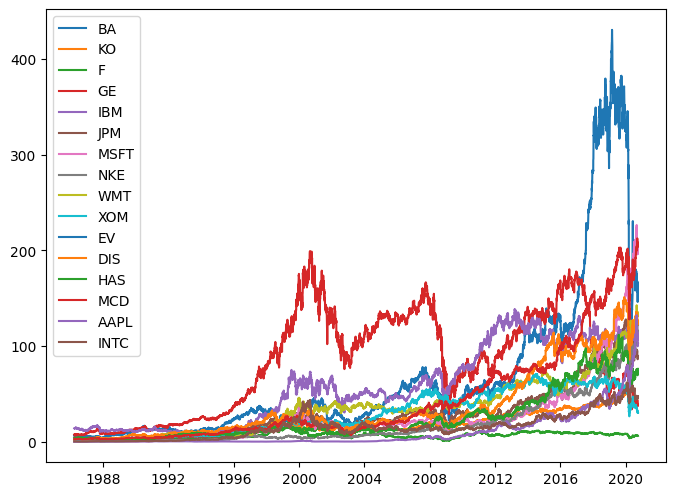

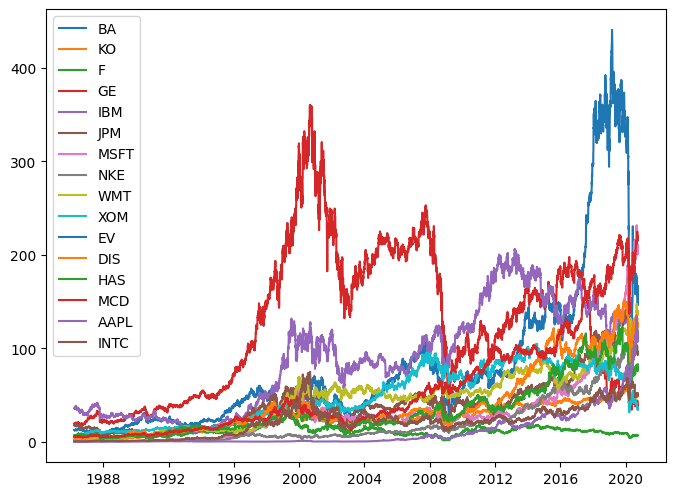

<ipython-input-12-60b76981648f>:323: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.array(_result)


(16, 8703)

In [12]:
# CREATES THE STOCK DATA CSV

import yfinance as yf
from pandas_datareader import data as pdr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# from data import read_stock_history, index_to_date, date_to_index, normalize, write_to_h5py
import h5py

print("Imports Complete!")


date_start = "1986-03-24"
date_end = "2020-10-01"


# Boeing symbol: BA
# Coca Cola symbol: KO
# Ford symbol: F
# IBM symbol: IBM
# GE symbol: GE
# JP Morgan symbol: JPM
# Microsoft symbol: MSFT
# Nike symbol: NKE
# Walmart symbol: WMT
# Exxon Mobil symbol: XOM
# Eaton Vance Corp: EV
# Clorox: CLX
# Disney: DIS
# Hasbro: HAS
# MC Donalds: MCD
# Apple : AAPL
# Intel: INTC

yf.pdr_override()
data_ba = pdr.get_data_yahoo("BA", start=date_start, end=date_end)
data_ko = pdr.get_data_yahoo("KO", start=date_start, end=date_end)
data_f = pdr.get_data_yahoo("F", start=date_start, end=date_end)
data_ibm = pdr.get_data_yahoo("IBM", start=date_start, end=date_end)
data_ge = pdr.get_data_yahoo("GE", start=date_start, end=date_end)
data_jpm = pdr.get_data_yahoo("JPM", start=date_start, end=date_end)
data_msft = pdr.get_data_yahoo("MSFT", start=date_start, end=date_end)
data_nke = pdr.get_data_yahoo("NKE", start=date_start, end=date_end)
data_wmt = pdr.get_data_yahoo("WMT", start=date_start, end=date_end)
data_xom = pdr.get_data_yahoo("XOM", start=date_start, end=date_end)
data_ev = pdr.get_data_yahoo("EV", start=date_start, end=date_end)
# data_clx = pdr.get_data_yahoo("CLX", start=date_start, end=date_end)
data_dis = pdr.get_data_yahoo("DIS", start=date_start, end=date_end)
data_has = pdr.get_data_yahoo("HAS", start=date_start, end=date_end)
data_mcd = pdr.get_data_yahoo("MCD", start=date_start, end=date_end)
data_aapl = pdr.get_data_yahoo("AAPL", start=date_start, end=date_end)
data_intc = pdr.get_data_yahoo("INTC", start=date_start, end=date_end)

# print("BA: ", data_ba.index[0])
# print("KO: ", data_ko.index[0])
# print("F: ", data_f.index[0])
# print("IBM: ", data_ibm.index[0])
# print("GE: ", data_ge.index[0])
# print("JPM: ", data_jpm.index[0])
# print("MSFT: ", data_msft.index[0])
# print("NKE: ", data_nke.index[0])
# print("WMT: ", data_wmt.index[0])
# print("XOM: ", data_xom.index[0])
# print("EV: ", data_ev.index[0])
# print("CLX: ", data_clx.index[0])
# print("DIS: ", data_dis.index[0])
# print("HAS: ", data_has.index[0])
# print("MCD: ", data_mcd.index[0])
# print("AAPL: ", data_aapl.index[0])
# print("INTC: ", data_intc.index[0])

# Interpolate
data_ba = data_ba.interpolate(method='polynomial', order=2)
data_ko = data_ko.interpolate(method='polynomial', order=2)
data_f = data_f.interpolate(method='polynomial', order=2)
data_ibm = data_ibm.interpolate(method='polynomial', order=2)
data_ge = data_ge.interpolate(method='polynomial', order=2)
data_jpm = data_jpm.interpolate(method='polynomial', order=2)
data_msft = data_msft.interpolate(method='polynomial', order=2)
data_nke = data_nke.interpolate(method='polynomial', order=2)
data_wmt = data_wmt.interpolate(method='polynomial', order=2)
data_xom = data_xom.interpolate(method='polynomial', order=2)
data_ev = data_ev.interpolate(method='polynomial', order=2)
# data_clx = data_clx.interpolate(method='polynomial', order=2)
data_dis = data_dis.interpolate(method='polynomial', order=2)
data_has = data_has.interpolate(method='polynomial', order=2)
data_mcd = data_mcd.interpolate(method='polynomial', order=2)
data_aapl = data_aapl.interpolate(method='polynomial', order=2)
data_intc = data_intc.interpolate(method='polynomial', order=2)


# Daily Returns 
data_ba_dailyReturns = data_ba["Adj Close"].pct_change(1) # 1 for ONE DAY lookback
data_ko_dailyReturns = data_ko['Adj Close'].pct_change(1)
data_f_dailyReturns = data_f['Adj Close'].pct_change(1)
data_ibm_dailyReturns = data_ibm['Adj Close'].pct_change(1)
data_ge_dailyReturns = data_ge['Adj Close'].pct_change(1)
data_jpm_dailyReturns = data_jpm['Adj Close'].pct_change(1)
data_msft_dailyReturns = data_msft['Adj Close'].pct_change(1)
data_nke_dailyReturns = data_nke['Adj Close'].pct_change(1)
data_wmt_dailyReturns = data_wmt['Adj Close'].pct_change(1)
data_xom_dailyReturns = data_xom['Adj Close'].pct_change(1)
data_ev_dailyReturns = data_ev['Adj Close'].pct_change(1)
# data_clx_dailyReturns = data_clx['Adj Close'].pct_change(1)
data_dis_dailyReturns = data_dis['Adj Close'].pct_change(1)
data_has_dailyReturns = data_has['Adj Close'].pct_change(1)
data_mcd_dailyReturns = data_mcd['Adj Close'].pct_change(1)
data_aapl_dailyReturns = data_aapl['Adj Close'].pct_change(1)
data_intc_dailyReturns = data_intc['Adj Close'].pct_change(1)


data_ba['Daily Return'] = data_ba_dailyReturns
data_ko['Daily Return'] = data_ko_dailyReturns
data_f['Daily Return'] = data_f_dailyReturns
data_ibm['Daily Return'] = data_ibm_dailyReturns
data_ge['Daily Return'] = data_ge_dailyReturns
data_jpm['Daily Return'] = data_jpm_dailyReturns
data_msft['Daily Return'] = data_msft_dailyReturns
data_nke['Daily Return'] = data_nke_dailyReturns
data_wmt['Daily Return'] = data_wmt_dailyReturns
data_xom['Daily Return'] = data_xom_dailyReturns
data_ev['Daily Return'] = data_ev_dailyReturns
# data_clx['Daily Return'] = data_clx_dailyReturns
data_dis['Daily Return'] = data_dis_dailyReturns
data_has['Daily Return'] = data_has_dailyReturns
data_mcd['Daily Return'] = data_mcd_dailyReturns
data_aapl['Daily Return'] = data_aapl_dailyReturns
data_intc['Daily Return'] = data_intc_dailyReturns


# Log Return
data_ba_logreturns = np.log(data_ba["Adj Close"]/data_ba["Adj Close"].shift(1))
data_ko_logreturns = np.log(data_ko['Adj Close']/data_ko['Adj Close'].shift(1))
data_f_logreturns = np.log(data_f['Adj Close']/data_f['Adj Close'].shift(1))
data_ibm_logreturns = np.log(data_ibm['Adj Close']/data_ibm['Adj Close'].shift(1))
data_ge_logreturns = np.log(data_ge['Adj Close']/data_ge['Adj Close'].shift(1))
data_jpm_logreturns = np.log(data_jpm['Adj Close']/data_jpm['Adj Close'].shift(1))
data_msft_logreturns = np.log(data_msft['Adj Close']/data_msft['Adj Close'].shift(1))
data_nke_logreturns = np.log(data_nke['Adj Close']/data_nke['Adj Close'].shift(1))
data_wmt_logreturns = np.log(data_wmt['Adj Close']/data_wmt['Adj Close'].shift(1))
data_xom_logreturns = np.log(data_xom['Adj Close']/data_xom['Adj Close'].shift(1))
data_ev_logreturns = np.log(data_ev['Adj Close']/data_ev['Adj Close'].shift(1))
# data_clx_logreturns = np.log(data_clx['Adj Close']/data_clx['Adj Close'].shift(1))
data_dis_logreturns = np.log(data_dis['Adj Close']/data_dis['Adj Close'].shift(1))
data_has_logreturns = np.log(data_has['Adj Close']/data_has['Adj Close'].shift(1))
data_mcd_logreturns = np.log(data_mcd['Adj Close']/data_mcd['Adj Close'].shift(1))
data_aapl_logreturns = np.log(data_aapl['Adj Close']/data_aapl['Adj Close'].shift(1))
data_intc_logreturns = np.log(data_intc['Adj Close']/data_intc['Adj Close'].shift(1))

data_ba['Log Return'] = data_ba_logreturns
data_ko['Log Return'] = data_ko_logreturns
data_f['Log Return'] = data_f_logreturns
data_ibm['Log Return'] = data_ibm_logreturns
data_ge['Log Return'] = data_ge_logreturns
data_jpm['Log Return'] = data_jpm_logreturns
data_msft['Log Return'] = data_msft_logreturns
data_nke['Log Return'] = data_nke_logreturns
data_wmt['Log Return'] = data_wmt_logreturns
data_xom['Log Return'] = data_xom_logreturns
data_ev['Log Return'] = data_ev_logreturns
# data_clx['Log Return'] = data_clx_logreturns
data_dis['Log Return'] = data_dis_logreturns
data_has['Log Return'] = data_has_logreturns
data_mcd['Log Return'] = data_mcd_logreturns
data_aapl['Log Return'] = data_aapl_logreturns
data_intc['Log Return'] = data_intc_logreturns

data_ev.head()
# # Check if all start correctly
# print("BA: ", data_ba.index[0], ", ", data_ba['Close'].iloc[0])
# print("KO: ", data_ko.index[0], ", ", data_ko['Close'].iloc[0])
# print("F: ", data_f.index[0], ", ", data_f['Close'].iloc[0])
# print("IBM: ", data_ibm.index[0], ", ", data_ibm['Close'].iloc[0])
# print("GE: ", data_ge.index[0], ", ", data_ge['Close'].iloc[0])
# print("JPM: ", data_jpm.index[0], ", ", data_jpm['Close'].iloc[0])
# print("MSFT: ", data_msft.index[0], ", ", data_msft['Close'].iloc[0])
# print("NKE: ", data_nke.index[0], ", ", data_nke['Close'].iloc[0])
# print("WMT: ", data_wmt.index[0], ", ", data_wmt['Close'].iloc[0])
# print("XOM: ", data_xom.index[0], ", ", data_xom['Close'].iloc[0])
# print("EV: ", data_ev.index[0], ", ", data_ev['Close'].iloc[0])
# print("CLX: ", data_clx.index[0], ", ", data_clx['Close'].iloc[0])
# print("DIS: ", data_dis.index[0], ", ", data_dis['Close'].iloc[0])
# print("HAR: ", data_has.index[0], ", ", data_has['Close'].iloc[0])
# print("MCD: ", data_mcd.index[0], ", ", data_mcd['Close'].iloc[0])
# print("AAPL: ", data_aapl.index[0], ", ", data_aapl['Close'].iloc[0])
# print("INTC: ", data_intc.index[0], ", ", data_intc['Close'].iloc[0])

# Remove first row:
#data_ba.drop(data_ba.index[:1], inplace=True)
#data_ko.drop(data_ko.index[:1], inplace=True)
#data_f.drop(data_f.index[:1], inplace=True)
#data_ibm.drop(data_ibm.index[:1], inplace=True)
#data_ge.drop(data_ge.index[:1], inplace=True)
#data_jpm.drop(data_jpm.index[:1], inplace=True)
#data_msft.drop(data_msft.index[:1], inplace=True)
#data_nke.drop(data_nke.index[:1], inplace=True)
#data_wmt.drop(data_wmt.index[:1], inplace=True)
#data_xom.drop(data_xom.index[:1], inplace=True)

# Add codes:
data_ba['Code'] = "BA"
data_ko['Code'] = "KO"
data_f['Code'] = "F"
data_ibm['Code'] = "IBM"
data_ge['Code'] = "GE"
data_jpm['Code'] = "JPM"
data_msft['Code'] = "MSFT"
data_nke['Code'] = "NKE"
data_wmt['Code'] = "WMT"
data_xom['Code'] = "XOM"
data_ev['Code'] = "EV"
# data_clx['Code'] = "CLX"
data_dis['Code'] = "DIS"
data_has['Code'] = "HAS"
data_mcd['Code'] = "MCD"
data_aapl['Code'] = "AAPL"
data_intc['Code'] = "INTC"

data_ko.head()

# Lets put all of this into one Dataframe
# frames = [data_ba, data_ko, data_f, data_ibm, data_ge, data_jpm, data_msft, data_nke, 
#           data_wmt, data_xom, data_ev, data_clx, data_dis, data_has, data_mcd, data_aapl, 
#           data_intc]
frames = [data_ba, data_ko, data_f, data_ibm, data_ge, data_jpm, data_msft, data_nke, 
          data_wmt, data_xom, data_ev, data_dis, data_has, data_mcd, data_aapl, 
          data_intc]

result_df = pd.concat(frames)

result_df.head()

# Save as CSV
#pd.DataFrame(result).to_csv(
#            'datasets/stock_data.csv', index=True)


#%% [code]
# PLOT ADJ CLOSE
plt.figure(figsize=(8, 6), dpi=100)
plt.plot(data_ba['Adj Close'],label="BA")
plt.plot(data_ko['Adj Close'],label="KO")
plt.plot(data_f['Adj Close'],label="F")
plt.plot(data_ge['Adj Close'],label="GE")
plt.plot(data_ibm['Adj Close'],label="IBM")
plt.plot(data_jpm['Adj Close'],label="JPM")
plt.plot(data_msft['Adj Close'],label="MSFT")
plt.plot(data_nke['Adj Close'],label="NKE")
plt.plot(data_wmt['Adj Close'],label="WMT")
plt.plot(data_xom['Adj Close'],label="XOM")
plt.plot(data_ev['Adj Close'],label="EV")
# plt.plot(data_clx['Adj Close'],label="CLX")
plt.plot(data_dis['Adj Close'],label="DIS")
plt.plot(data_has['Adj Close'],label="HAS")
plt.plot(data_mcd['Adj Close'],label="MCD")
plt.plot(data_aapl['Adj Close'],label="AAPL")
plt.plot(data_intc['Adj Close'],label="INTC")

plt.legend()
plt.show()

# PLOT CLOSE
plt.figure(figsize=(8, 6), dpi=100)
plt.plot(data_ba['Close'],label="BA")
plt.plot(data_ko['Close'],label="KO")
plt.plot(data_f['Close'],label="F")
plt.plot(data_ge['Close'],label="GE")
plt.plot(data_ibm['Close'],label="IBM")
plt.plot(data_jpm['Close'],label="JPM")
plt.plot(data_msft['Close'],label="MSFT")
plt.plot(data_nke['Close'],label="NKE")
plt.plot(data_wmt['Close'],label="WMT")
plt.plot(data_xom['Close'],label="XOM")
plt.plot(data_ev['Close'],label="EV")
# plt.plot(data_clx['Close'],label="CLX")
plt.plot(data_dis['Close'],label="DIS")
plt.plot(data_has['Close'],label="HAS")
plt.plot(data_mcd['Close'],label="MCD")
plt.plot(data_aapl['Close'],label="AAPL")
plt.plot(data_intc['Close'],label="INTC")

plt.legend()
plt.show()

## Save H5 with Open, Low, High, Close
#Result is to be (assets, dates, features)


assets = ['BA', 'KO', 'F', 'GE', 'IBM', 'JPM', 'MSFT', 'NKE', 'WMT', 
          'XOM', 'EV', 'CLX', 'DIS', 'HAS', 'MCD', 'AAPL', 'INTC']
data = [data_ba.values.tolist(), 
        data_ko.values.tolist(), 
        data_f.values.tolist(), 
        data_ge.values.tolist(), 
        data_ibm.values.tolist(), 
        data_jpm.values.tolist(), 
        data_msft.values.tolist(), 
        data_nke.values.tolist(), 
        data_wmt.values.tolist(), 
        data_xom.values.tolist(), 
        data_ev.values.tolist(), 
        # data_clx.values.tolist(), 
        data_dis.values.tolist(), 
        data_has.values.tolist(), 
        data_mcd.values.tolist(), 
        data_aapl.values.tolist(),
        data_intc.values.tolist()]    
dates = data_ba.index.tolist()
dates = [date_obj.strftime('%d/%m/%Y') for date_obj in data_ba.index.tolist()]

data[0]

		 
_result = []
for i in range(len(data)): # ASSET
    _asset = []
    for j in range(len(data[0])): # DATES
        _asset.append(data[i][:4])
    _result.append(_asset)


result = np.array(_result)


# result


result.shape

# abb = [abbr.encode() for abbr in assets]
# write_to_h5py(result, abb, dates, "datasets/yahoo_snp500_dataset.h5")








In [19]:
# with h5py.File('datasets/yahoo_snp500_dataset.h5', 'r') as f:
#     history = f['history'][:]
#     abbreviation = f['abbreviation'][:].tolist()
#     dates = f['dates'][:].tolist()


# import datetime
# dates = [datetime.datetime.strptime(date_str, '%d/%m/%Y') for date_str in dates]


# # dates

		 
		
# # history
# # abbreviation

# history[10]

with h5py.File('/content/utils/datasets/SP500.h5', 'r') as f:
    history = f['history'][:]
    abbreviation = f['abbreviation'][:].tolist()
    dates = f['dates'][:].tolist()


import datetime
# dates = [datetime.datetime.strptime(date_str, '%d/%m/%Y') for date_str in dates]


# dates

		 
		
# history
# abbreviation

history[10]



array([[  3.75      ,   3.8125    ,   3.6875    ,   3.6953125 ],
       [  3.6875    ,   3.71875   ,   3.40625   ,   3.59375   ],
       [  3.90625   ,   3.96875   ,   3.71875   ,   3.734375  ],
       ...,
       [487.97000122, 489.39001465, 481.17999268, 488.51000977],
       [489.94000244, 493.45001221, 484.17001343, 489.32998657],
       [488.13000488, 497.23999023, 486.22000122, 490.42999268]])

In [30]:
import datetime
dates = [datetime.datetime.strptime(date_str, '%d/%m/%Y') for date_str in dates]


TypeError: ignored

In [20]:
# Get Close
_history = history[:, :, :4]
# Target Stocks
target_stocks = abbreviation
# Target History
target_history = np.empty(shape=(len(target_stocks), _history.shape[1], _history.shape[2]))
for i, stock in enumerate(target_stocks):
    target_history[i] = _history[abbreviation.index(stock), :, :]

print("Assets: ", target_stocks)
print("Target History Sample: ", target_history[0][0])
print("Target History Shape: ", target_history.shape)
# Get Close
_history = history[:, :, :4]
# Target Stocks
target_stocks = abbreviation
# Target History
target_history = np.empty(shape=(len(target_stocks), _history.shape[1], _history.shape[2]))
for i, stock in enumerate(target_stocks):
    target_history[i] = _history[abbreviation.index(stock), :, :]

print("Assets: ", target_stocks)
print("Target History Sample: ", target_history[0][0])
print("Target History Shape: ", target_history.shape)

Assets:  [b'AAPL', b'MSFT', b'JNJ', b'JPM', b'PG', b'UNH', b'HD', b'DIS', b'VZ', b'CMCSA', b'ADBE', b'PFE', b'BAC', b'INTC', b'T', b'WMT', b'MRK', b'KO', b'PEP', b'ABT', b'TMO', b'CSCO', b'CVX', b'NKE', b'XOM']
Target History Sample:  [0.3470982  0.3470982  0.33816963 0.34263393]
Target History Shape:  (25, 6483, 4)
Assets:  [b'AAPL', b'MSFT', b'JNJ', b'JPM', b'PG', b'UNH', b'HD', b'DIS', b'VZ', b'CMCSA', b'ADBE', b'PFE', b'BAC', b'INTC', b'T', b'WMT', b'MRK', b'KO', b'PEP', b'ABT', b'TMO', b'CSCO', b'CVX', b'NKE', b'XOM']
Target History Sample:  [0.3470982  0.3470982  0.33816963 0.34263393]
Target History Shape:  (25, 6483, 4)


In [11]:
# common settings
batch_size = 64
action_bound = 1.
tau = 1e-3

models = []
model_names = []
framework_lst = ['TD3']
window_length_lst = [3]
maximum_window = max(window_length_lst)
predictor_type_lst = ['lstm']
use_batch_norm = True
log_return = True
technical_indicators_flag = False
load_technical_indicators = True

#%% [code]
# Stock History
dataset_name = 'nyse_o'
history, assets, date_list = read_stock_history(filepath='utils/datasets/{}.h5'.format(dataset_name))
history = history[:, :, :4]
nb_classes = len(history) + 1
print("Dataset: {}".format(dataset_name))
print("Assets: {}".format(assets))
print("Stock History Shape: {}".format(history.shape))
print("Full Stock History Date Range: {} -> {}".format(date_list[0], date_list[-1]))

OSError: ignored

In [6]:
from __future__ import print_function, division

from model.ddpg.actor import ActorNetwork
from model.ddpg.critic import CriticNetwork
from model.ddpg.ddpg import DDPG
from model.ornstein_uhlenbeck import OrnsteinUhlenbeckActionNoise
from model.td3.actor import TD3ActorNetwork
from model.td3.critic import TD3CriticNetwork
from model.td3.td3 import TD3
from model.benchmarks_olps import algos
from environment.portfolio import PortfolioEnv, max_drawdown, sharpe, sortino, create_close_dataframe, convert_prices
from utils.data import read_stock_history, normalize
from technical_indicators.technical_indicators import full_rmr_moving_average, olmar_moving_average
import numpy as np
import tflearn
import tensorflow as tf
import argparse
import pprint
import pandas as pd
import matplotlib.pyplot as plt
import json
import sys


Instructions for updating:
non-resource variables are not supported in the long term
